# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [34]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [35]:
# recherche fichiers POIDS : format data_BEN_xxxxxx.zip

# Source : Withings https://healthmate.withings.com/

# Account > User > Parameters > Download ==> data_BEN_xxxxx.zip ==> contient weight.csv

pattern_poids = "^data_BEN_[\d]+[.]zip"
eng = re.compile(pattern_poids)
liste_zip_poids = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un data_BEN_dddd.zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_poids.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_poids) == 0:
    raise NameError(f'Aucun fichier de type data_BEN_xxxx.zip contenant \
        les données poids ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_poids)

idx = np.argmax(liste_mtime_zips)
filename_poids = liste_zip_poids[idx]

print(f"Le fichier poids le plus récent est : {filename_poids}, parmi :\n")
for f in liste_zip_poids:
    print(f"{f}")

Le fichier poids le plus récent est : data_BEN_1693540506.zip, parmi :

data_BEN_1693022338.zip
data_BEN_1692849636.zip
data_BEN_1693455099.zip
data_BEN_1693363579.zip
data_BEN_1693279234.zip
data_BEN_1692763395.zip
data_BEN_1693197685.zip
data_BEN_1693106911.zip
data_BEN_1693540506.zip
data_BEN_1692933121.zip


In [36]:
# recherche fichiers FOOD : format File-Export-YYYY-MM-DD-to-YYYY-MM-DD.zip

# https://www.myfitnesspal.com/reports

# www.myfitnesspal.com ==> reports > export data ==> File-Export-date1-to-date2.zip

pattern_food = "^File-Export-[\d]{4}-[\d]{2}-[\d]{2}-to-[\d]{4}-[\d]{2}-[\d]{2}.*[.]zip"
eng = re.compile(pattern_food)
liste_zip_food = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un File-Export-....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_food.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_food) == 0:
    raise NameError(f'Aucun fichier de type File-Export-xxxx.zip contenant \
        les données food ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_food)

idx = np.argmax(liste_mtime_zips)
filename_food = liste_zip_food[idx]

print(f"Le fichier food le plus récent est : {filename_food}, parmi \n")

for f in liste_zip_food:
    print(f"{f}")

Le fichier food le plus récent est : File-Export-2020-08-03-to-2023-09-01.zip, parmi 

File-Export-2020-08-03-to-2023-08-24.zip
File-Export-2020-08-03-to-2023-09-01.zip
File-Export-2020-08-03-to-2023-08-30.zip
File-Export-2020-08-03-to-2023-08-29.zip
File-Export-2020-08-03-to-2023-08-28.zip
File-Export-2020-08-03-to-2023-08-25 (2).zip
File-Export-2020-08-03-to-2023-08-27.zip
File-Export-2020-08-03-to-2023-08-22.zip
File-Export-2020-08-03-to-2023-08-26.zip
File-Export-2020-08-03-to-2023-08-31.zip
File-Export-2020-08-03-to-2023-08-23.zip


In [37]:
# recherche fichiers EXO par POLAR : format polar-user-data-export.zip

# https://account.polar.com/#export ==> polar-user-data-export-xxxxx.zip

pattern_polar = "^polar-user-data-export_.+[.]zip"
eng = re.compile(pattern_polar)
liste_zip_polar = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un polar-user-data-export_....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_polar.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_polar) == 0:
    raise NameError(f'Aucun fichier de type polar-user-data-export_xxxx.zip contenant \
        les données exercices de Polar ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_polar)

idx = np.argmax(liste_mtime_zips)
filename_polar = liste_zip_polar[idx]

print(f"Le fichier exercices le plus récent est : {filename_polar}, parmi :\n")

for f in liste_zip_polar:
    print(f"{f}")

Le fichier exercices le plus récent est : polar-user-data-export_9e0816c6-c7d2-44fb-8a31-67fbe41e4083.zip, parmi :

polar-user-data-export_9e0816c6-c7d2-44fb-8a31-67fbe41e4083.zip
polar-user-data-export_b6f9acd2-aa95-45b3-86ca-d1952ba19e1d.zip


In [38]:
# copie les trois fichiers sélectionnés dans le répertoire de travail

import_pathname = '/home/benjamin/Folders_Python/Weight_imports/'

src = [filename_food,
       filename_poids,
       filename_polar]

dst = ['food', 'poids', 'polar']

for s,d in zip(src, dst):
       shutil.copy(downloads_rep + s, import_pathname + d)
       
print(f"Utilise : {filename_food}, {filename_poids}, {filename_polar}")

Utilise : File-Export-2020-08-03-to-2023-09-01.zip, data_BEN_1693540506.zip, polar-user-data-export_9e0816c6-c7d2-44fb-8a31-67fbe41e4083.zip


In [39]:
# Récupère données POIDS

withings_filename = import_pathname + 'poids'  # fichier zip le plus récent de HealthMate Withings

with ZipFile(withings_filename, 'r') as weight_zip:
    weight_csv = weight_zip.extract('weight.csv', path=import_pathname)

# extrait la dataframe poids ----------------

colnames = ['Date', 'Poids (kg)', 'Gras (kg)', 'Masse osseuse (kg)', 'Masse musculaire (kg)', 'Hydratation (kg)']

df_weight = pd.read_csv(weight_csv, usecols=colnames)

os.remove(weight_csv)

df_weight.rename(columns = {'Poids (kg)' : 'Masse_Totale' , 
                            'Gras (kg)' : 'Masse_Grasse',
                            'Masse osseuse (kg)' : 'Masse_Osseuse',
                            'Masse musculaire (kg)' : 'Masse_Musculaire',
                            'Hydratation (kg)' : 'Masse_Hydrique'
                            }, 
                 inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d %H:%M:%S'

df_weight['Date'] = df_weight['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_weight = df_weight.groupby('Date').mean()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_weight = df_weight[df_weight.index >= start_date]

subset = ['Masse_Totale', 'Masse_Grasse']
df_weight.dropna(subset = subset, inplace=True)

# df_weight['Masse_Maigre'] = df_weight['Masse_Totale'] - df_weight['Masse_Grasse']
df_weight['MG%'] = df_weight['Masse_Grasse'] / df_weight['Masse_Totale']
df_weight['BMR'] = 370 + 21.6 * (df_weight['Masse_Totale'] - df_weight['Masse_Grasse'])

df_weight.sort_index(inplace=True)

In [40]:
# forward propagate actual values into NaN
df_weight.fillna(method="ffill", inplace=True)

In [41]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-08-18,71.192500,10.516250,3.045000,57.617500,41.198750,0.147716,1680.607000
2023-08-19,71.282857,9.971429,3.087143,58.204286,42.102857,0.139885,1694.326857
2023-08-20,71.355000,10.460000,3.058750,57.822500,41.448750,0.146591,1685.332000
2023-08-21,71.185714,10.660000,3.035714,57.474286,40.990000,0.149749,1677.355429
2023-08-22,71.421250,10.446250,3.062500,57.896250,41.535000,0.146262,1687.060000
2023-08-23,71.333333,10.888889,3.030000,57.400000,40.835556,0.152648,1675.600000
2023-08-24,70.597000,10.664000,3.003000,56.914000,40.384000,0.151055,1664.552800
2023-08-25,71.104444,10.456667,3.044444,57.588889,41.191111,0.147061,1679.992000
2023-08-26,72.056250,10.177500,3.118750,58.741250,42.601250,0.141244,1706.581000


In [42]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-08-18,71.867219,10.796760,3.064107,57.992602,41.508469,0.150203,1689.121918
2023-08-19,71.648520,10.551071,3.068342,58.014464,41.627092,0.147249,1689.704898
2023-08-20,71.511735,10.486071,3.065128,57.946071,41.578520,0.146627,1688.154327
2023-08-21,71.389872,10.478393,3.058622,57.837577,41.464056,0.146774,1685.687959
2023-08-22,71.354745,10.472755,3.057347,57.809694,41.435791,0.146767,1685.050980
2023-08-23,71.293971,10.475096,3.053954,57.749872,41.371763,0.146929,1683.687694
2023-08-24,71.195379,10.515260,3.046015,57.618403,41.213559,0.147701,1680.690584
2023-08-25,71.182800,10.506748,3.045936,57.614316,41.212468,0.147607,1680.602727
2023-08-26,71.293285,10.536187,3.050451,57.691025,41.283667,0.147801,1682.353318


In [43]:
# Récupère données FOOD

mfp_filename = import_pathname + "food" # données de My Fitness Pal

# Extrait les archives
    
with ZipFile(mfp_filename, 'r') as food_zip:
    output_dir = food_zip.namelist()
    target = 'Nutrition-Summary'
    for l in output_dir:
        if l[:len(target)] == target:
            food_csv = food_zip.extract(l, path=import_pathname)
            break
        
# extrait la dataframe food -------------------------------

colnames = ['Date', 'Meal', 'Calories', 'Fat (g)', 'Carbohydrates (g)', 'Protein (g)']

df_food = pd.read_csv(food_csv, usecols=colnames)
os.remove(food_csv)

df_food.rename(columns = {'Fat (g)' : 'Lipides' , 'Carbohydrates (g)' : 'Glucides', 'Protein (g)' : 'Proteines'}, inplace=True)

In [44]:
# df_food.tail(15)

In [45]:
# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d'

df_food['Date'] = df_food['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_food = df_food.groupby('Date').sum(numeric_only=True)

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_food = df_food[df_food.index >= start_date]
df_food.dropna(inplace=True)
df_food.sort_index(inplace=True)

In [46]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-08-17,1726.1,28.5,202.1,165.9
2023-08-18,1707.1,22.6,202.2,176.5
2023-08-19,1731.0,34.8,178.0,176.7
2023-08-20,1832.4,32.3,186.0,201.0
2023-08-21,2120.4,57.9,215.0,184.9
2023-08-22,1687.3,32.9,142.9,209.0
2023-08-23,1717.6,29.9,174.3,190.8
2023-08-24,1721.4,19.5,223.3,166.0
2023-08-25,1793.0,51.5,205.0,63.1


In [47]:
df_food.rolling(window=7).mean().tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-08-17,1760.785714,37.185714,182.885714,163.328571
2023-08-18,1759.942857,34.714286,184.800000,167.228571
2023-08-19,1756.100000,34.042857,185.671429,170.442857
2023-08-20,1762.042857,34.157143,181.642857,176.285714
2023-08-21,1816.814286,37.628571,189.371429,177.328571
2023-08-22,1789.971429,36.385714,183.142857,183.414286
2023-08-23,1788.842857,34.128571,185.785714,186.400000
2023-08-24,1788.171429,32.842857,188.814286,186.414286
2023-08-25,1800.442857,36.971429,189.214286,170.214286


In [48]:
def extract_data_training(exo_dict):
    # utility fonction pour récupérer : date, durée, type exercice et calories dépensées
    
    # récupère date
    pattern = '2(\d){3,3}-(\d){2,2}-(\d){2,2}'  # on cherche une date du type 2xxx-yy-zz
    p = re.compile(pattern)
    m = p.search(exo_dict.get('startTime'))
    if m: 
        time_format = '%Y-%m-%d'
        exo_date = datetime.datetime.strptime( exo_dict.get('startTime')[:10], time_format ).date()
    
    # récupère durée
    pattern = '(\d)+[.]?(\d)*'  # on cherche une durée du type xxxx.yyyy
    p = re.compile(pattern)
    m = p.search(exo_dict.get('duration'))
    if m:
        exo_duration = float(m.group())
    
    # récupère type activité et calories dépensées
    d = exo_dict.get('exercises')[0]   
    exo_type = d.get('sport')
    if d.get('kiloCalories'):
        exo_cals = float(d.get('kiloCalories'))
    else:
        exo_cals = 0.0
    
    return exo_date, exo_duration, exo_type, exo_cals

In [49]:
# Récupère les données EXERCICE

polar_filename = import_pathname + "polar"  # données de Polar

with ZipFile(polar_filename, 'r') as polar_zip:
    output_dir = polar_zip.namelist()
    
    target = 'training-session'
    dict_all_exos = {}
    for i, enr_name in enumerate(tqdm(output_dir)): # on parcourt la liste des archives
        if enr_name[:len(target)] == target:  # si c'est un enregistrement d'une session de training, on traite
            enr_json = polar_zip.extract(enr_name, path=import_pathname)   # extraction du json
            with open(enr_json, 'r') as f:
                exo_dict = json.load(f)
                exo_date, exo_duration, exo_type, exo_cals = extract_data_training(exo_dict)
                if dict_all_exos.get(exo_date) == None:
                    dict_all_exos[exo_date] = [ exo_duration, exo_cals]
                else:
                    dict_all_exos[exo_date] = [ dict_all_exos[exo_date][0] + exo_duration, dict_all_exos[exo_date][1] + exo_cals ]
                # print(f'exercice {i+1} : date = {exo_date}, durée = {exo_duration}, type = {exo_type}, cals = {exo_cals}')
            os.remove(enr_json)
    
    df_exos = pd.DataFrame.from_dict(dict_all_exos, orient='index', columns=['exo_duree', 'exo_cals_bruts']).sort_index()

100%|██████████| 1574/1574 [00:15<00:00, 102.99it/s]


In [50]:
df_exos.tail(15)

,exo_duree,exo_cals_bruts
2023-08-04,5586.925,972.0
2023-08-05,2940.000,200.0
2023-08-06,5700.836,590.0
2023-08-07,1702.971,236.0
2023-08-08,1808.967,298.0
2023-08-09,7577.962,776.0
2023-08-10,1700.637,241.0
2023-08-12,5280.712,529.0
2023-08-13,1800.539,245.0
2023-08-15,3120.712,522.0


In [51]:
# Ajout à la main des exos depuis le xx Janvier inclus pour palier à la fréquence de rafraîchissement de l'extraction Polar

# récupère fichier brut .csv
exos_persos_filename = "/home/benjamin/Folders_Python/Weight_imports/Exos_Persos.csv"
df_exos_persos = pd.read_csv(exos_persos_filename)

# convertit la colonne Jour en datetime objects en colonne Date
pattern_date = '[\d]{2}/[\d]{2}/[\d]{2}'
p = re.compile(pattern_date)

day_format = "%d/%m/%y"

df_exos_persos['Date'] = df_exos_persos['Jour'].apply( lambda x : datetime.datetime.strptime(p.search(x).group(0), day_format).date() )

# drope la colonne Jour, somme tous les exercices par date
df_exos_persos.drop(columns=['Jour'], inplace=True)

df_exos_persos = df_exos_persos.groupby('Date').sum()

# met au bon format la duree de l'exercice (minutes => secondes)
df_exos_persos['exo_duree'] = df_exos_persos['Duree'] * 60
df_exos_persos.drop(columns=['Duree'], inplace=True)

In [52]:
df_exos_persos

,exo_cals_bruts,exo_duree
Date,,
2023-08-22,356,2340
2023-08-23,280,3660
2023-08-24,0,0
2023-08-25,341,2940
2023-08-26,255,1740
2023-08-27,474,5280
2023-08-28,218,1740
2023-08-29,0,0
2023-08-30,177,1260


In [53]:
# enfin, concatène avec le fichier issu de Polar
df_exos_total = pd.concat( [df_exos, df_exos_persos], axis=0 ).sort_index()

In [54]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
2023-08-16,3300.723,339.0
2023-08-17,1800.783,240.0
2023-08-18,3060.740,293.0
2023-08-20,5220.729,442.0
2023-08-21,1862.070,221.0
2023-08-22,2340.000,356.0
2023-08-23,3660.000,280.0
2023-08-24,0.000,0.0
2023-08-25,2940.000,341.0
2023-08-26,1740.000,255.0


In [55]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
2023-08-16,3512.893143,421.428571
2023-08-17,3511.724000,413.142857
2023-08-18,2866.406571,344.142857
2023-08-20,3369.276857,372.857143
2023-08-21,2880.899429,328.857143
2023-08-22,2957.965286,344.714286
2023-08-23,3035.006429,310.142857
2023-08-24,2563.474571,261.714286
2023-08-25,2726.219857,276.142857
2023-08-26,2537.542714,270.714286


In [56]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [57]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [58]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [59]:
# df_all.head(20)
# df_all.describe(include='all')
# df_all.info()

In [60]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-08-17,71.287143,10.382857,3.058571,57.834286,41.491429,0.145648,1685.532571,1726.1,28.5,202.1,165.9,1800.783,240.0,204.869463,1890.402034,-164.302034
2023-08-18,71.192500,10.516250,3.045000,57.617500,41.198750,0.147716,1680.607000,1707.1,22.6,202.2,176.5,3060.740,293.0,233.464108,1914.071108,-206.971108
2023-08-19,71.282857,9.971429,3.087143,58.204286,42.102857,0.139885,1694.326857,1731.0,34.8,178.0,176.7,0.000,0.0,0.000000,1694.326857,36.673143
2023-08-20,71.355000,10.460000,3.058750,57.822500,41.448750,0.146591,1685.332000,1832.4,32.3,186.0,201.0,5220.729,442.0,340.163638,2025.495638,-193.095638
2023-08-21,71.185714,10.660000,3.035714,57.474286,40.990000,0.149749,1677.355429,2120.4,57.9,215.0,184.9,1862.070,221.0,184.850078,1862.205507,258.194493
2023-08-22,71.421250,10.446250,3.062500,57.896250,41.535000,0.146262,1687.060000,1687.3,32.9,142.9,209.0,2340.000,356.0,310.308792,1997.368792,-310.068792
2023-08-23,71.333333,10.888889,3.030000,57.400000,40.835556,0.152648,1675.600000,1717.6,29.9,174.3,190.8,3660.000,280.0,209.019722,1884.619722,-167.019722
2023-08-24,70.597000,10.664000,3.003000,56.914000,40.384000,0.151055,1664.552800,1721.4,19.5,223.3,166.0,0.000,0.0,0.000000,1664.552800,56.847200
2023-08-25,71.104444,10.456667,3.044444,57.588889,41.191111,0.147061,1679.992000,1793.0,51.5,205.0,63.1,2940.000,341.0,283.833606,1963.825606,-170.825606
2023-08-26,72.056250,10.177500,3.118750,58.741250,42.601250,0.141244,1706.581000,1651.1,30.0,174.6,173.1,1740.000,255.0,220.631355,1927.212355,-276.112355


In [61]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-08-17,72.119923,10.928929,3.069515,58.107449,41.584566,0.151502,1691.725490,1760.785714,37.185714,182.885714,163.328571,2186.209857,267.857143,225.105881,1916.831371,-156.045656
2023-08-18,71.867219,10.796760,3.064107,57.992602,41.508469,0.150203,1689.121918,1759.942857,34.714286,184.800000,167.228571,2623.458429,309.714286,258.457896,1947.579815,-187.636958
2023-08-19,71.648520,10.551071,3.068342,58.014464,41.627092,0.147249,1689.704898,1756.100000,34.042857,185.671429,170.442857,1869.071000,234.142857,197.644573,1887.349471,-131.249471
2023-08-20,71.511735,10.486071,3.065128,57.946071,41.578520,0.146627,1688.154327,1762.042857,34.157143,181.642857,176.285714,2357.669571,262.285714,216.289063,1904.443390,-142.400533
2023-08-21,71.389872,10.478393,3.058622,57.837577,41.464056,0.146774,1685.687959,1816.814286,37.628571,189.371429,177.328571,2623.679571,293.857143,242.696217,1928.384176,-111.569891
2023-08-22,71.354745,10.472755,3.057347,57.809694,41.435791,0.146767,1685.050980,1789.971429,36.385714,183.142857,183.414286,2512.149286,270.142857,221.182697,1906.233676,-116.262248
2023-08-23,71.293971,10.475096,3.053954,57.749872,41.371763,0.146929,1683.687694,1788.842857,34.128571,185.785714,186.400000,2563.474571,261.714286,211.810829,1895.498523,-106.655666
2023-08-24,71.195379,10.515260,3.046015,57.618403,41.213559,0.147701,1680.690584,1788.171429,32.842857,188.814286,186.414286,2306.219857,227.428571,182.543763,1863.234346,-75.062918
2023-08-25,71.182800,10.506748,3.045936,57.614316,41.212468,0.147607,1680.602727,1800.442857,36.971429,189.214286,170.214286,2288.971286,234.285714,189.739405,1870.342132,-69.899275
2023-08-26,71.293285,10.536187,3.050451,57.691025,41.283667,0.147801,1682.353318,1789.028571,36.285714,188.728571,169.700000,2537.542714,270.714286,221.258170,1903.611489,-114.582917


# Graphes

In [62]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [63]:
def plot_general(longueur=15,
                 year=2023,
                 month=5,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

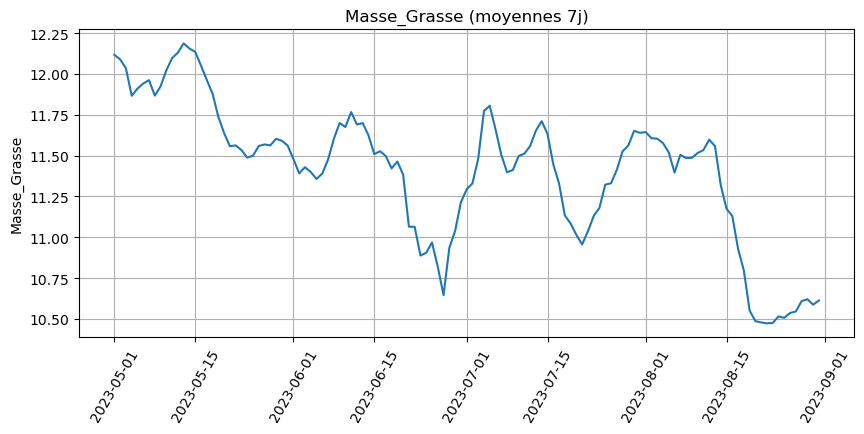

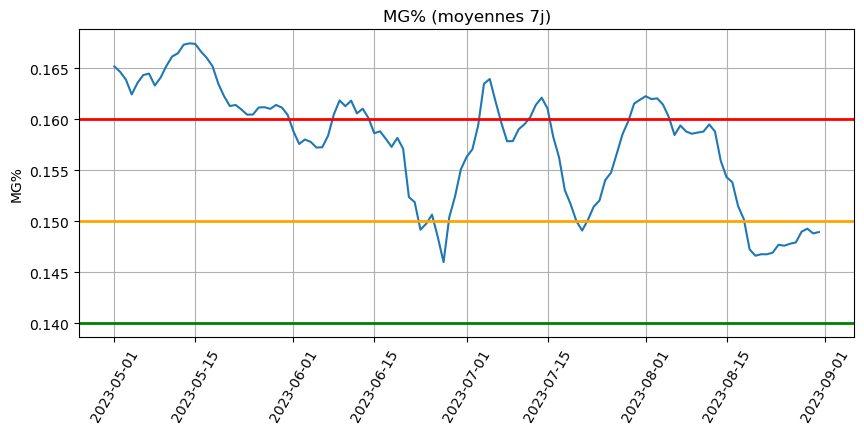

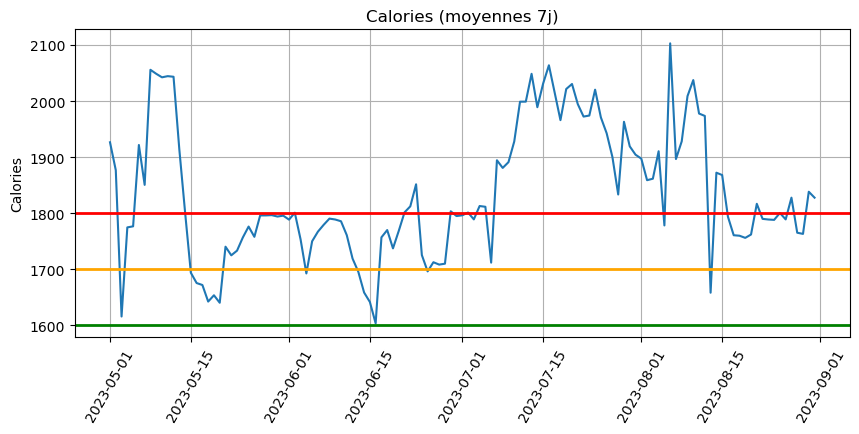

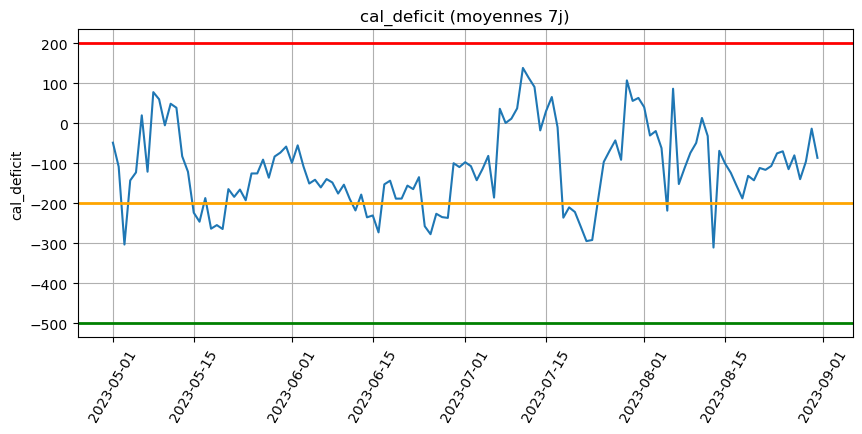

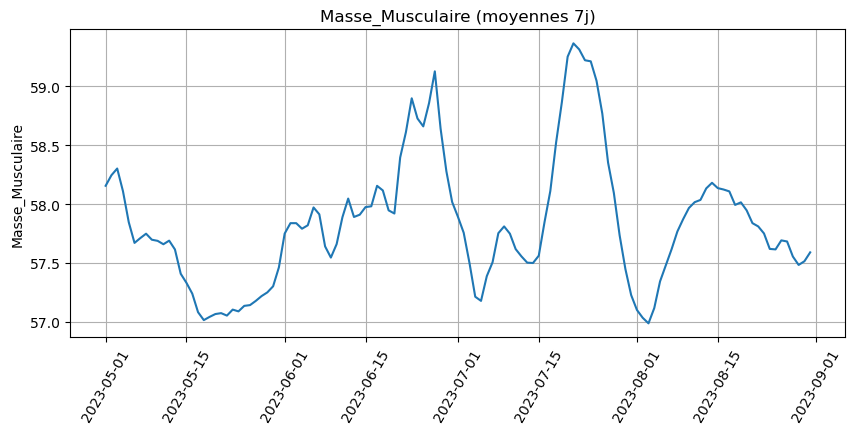

In [64]:
plot_general(longueur=7)

In [65]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general(longueur=15, year=2023, month=5, day=1)>

In [66]:
def plot_general2(longueur=15,
                 year=2023,
                 month=5,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [67]:
ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general2(longueur=15, year=2023, month=5, day=1)>

In [68]:
def plot_general3(longueur=15,
                 year=2023,
                 month=5,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [69]:
ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general3(longueur=15, year=2023, month=5, day=1)>

In [70]:
def scatter_plot(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['cal_deficit'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    # print(delta)
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie deficit over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight change (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=-500, stop=500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')
    

In [71]:
ipywidgets.interact(scatter_plot, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=2.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot(mass_interval=2.0, length=15)>

In [72]:
def scatter_plot2(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [73]:
ipywidgets.interact(scatter_plot2, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=2.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot2(mass_interval=2.0, length=15)>

In [74]:
def scatter_plot3(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_MG'] = (df_corr['Masse_Grasse'] - df_corr['Masse_Grasse'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_MG'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly fat mass variation over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [75]:
ipywidgets.interact(scatter_plot3, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=2.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot3(mass_interval=2.0, length=15)>